In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import datetime
from datetime import timedelta
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

In [3]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

In [4]:
# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    month = 'month'
    status = 'status'

In [5]:
# import starting data, filename path structure is : s3://unitrento/dc_events_timestamp/year=202X/month=XX/day=XX/output.snappy.parquet

df=pd.read_csv("Data/preprocessed_data_2021.csv", low_memory=False)

In [6]:
# Data sample
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
df[ColumnsOutput.status] = "False"
df

,Unnamed: 0,ddc_barcode,ddc_ipcode,ddc_mch_code,ddc_mch_side,ddc_ev_subcode,ddc_ev_timestamp,c_machine,month,y-m-day,status
0,0,9436800087,37887,1305,R,LO_LOADER_IN_PRESS,2021-12-17 09:15:23,False,12,21-12-17,False
1,1,9436800087,37887,1305,R,LO_BLADDER_VACUUM,2021-12-17 09:15:27,False,12,21-12-17,False
2,2,9436800087,37887,1305,R,LO_BLADDER_PRESHAPING,2021-12-17 09:15:27,False,12,21-12-17,False
3,3,9436800087,37887,1305,R,LO_LOADER_DOWN,2021-12-17 09:15:34,False,12,21-12-17,False
4,4,9436800087,37887,1305,R,LO_TCR_DOWN,2021-12-17 09:15:38,False,12,21-12-17,False
5,5,9436800087,37887,1305,R,LO_PRESHAPING,2021-12-17 09:15:41,False,12,21-12-17,False
6,6,9436800087,37887,1305,R,LO_LOADER_UP,2021-12-17 09:15:56,False,12,21-12-17,False
7,7,9436800087,37887,1305,R,LO_LOADER_RELEASE_TIRE,2021-12-17 09:15:56,False,12,21-12-17,False
8,8,9436800087,37887,1305,R,LO_LOADER_OUT,2021-12-17 09:15:58,False,12,21-12-17,False
9,9,9436800087,37887,1305,R,CL_UNLOCK_PRESS,2021-12-17 09:16:02,False,12,21-12-17,False


### Missing values analysis

In [7]:
missing_values = df.isnull().sum() / len(df)
missing_values = missing_values[missing_values>0]
missing_values

Series([], dtype: float64)

There are not missing values in the dataset, so each step is define with event and timestamp without misses

In [8]:
last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['last']).reset_index()
first_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg('first').reset_index()
first_last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first', 'last']).reset_index()
print(len(last_indexes))
print(len(first_indexes))
first_last_indexes

28189
28189


,ddc_barcode,first,last
0,9430887732,LO_LOADER_IN_PRESS,UN_FORK_OUT
1,9430887737,LO_LOADER_IN_PRESS,UN_FORK_OUT
2,9430888020,LO_LOADER_IN_PRESS,UN_FORK_OUT
3,9430890266,LO_LOADER_IN_PRESS,UN_FORK_OUT
4,9430890274,LO_LOADER_IN_PRESS,UN_FORK_OUT
5,9430890277,LO_LOADER_IN_PRESS,UN_FORK_OUT
6,9435411478,LO_LOADER_IN_PRESS,UN_UNLOADER_OUT
7,9435411953,LO_LOADER_IN_PRESS,UN_UNLOADER_OUT
8,9435411967,LO_LOADER_IN_PRESS,UN_UNLOADER_OUT
9,9435411976,LO_LOADER_IN_PRESS,UN_UNLOADER_OUT


### Press analysis
Different stats by press machines

##### Tyre per press' arm during one day

In [9]:
#machines names
machines = df[ColumnsInput.machine].unique()
df_per_day = []
days = []
for day in df[ColumnsOutput.day].unique():
    days.append(str(day))
    df_per_day.append(df[df[ColumnsOutput.day] == day])
    print(day, df[df[ColumnsOutput.day] == day].shape)
for i in range(len(df_per_day)):
    df_per_day[i] = df_per_day[i].groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
    df_per_day[i] = df_per_day[i].reset_index()
    count = 0
    tmp = []
    for mach in machines:
        if mach not in df_per_day[i][ColumnsInput.machine].unique():
            count += 1
            tmp.append({ColumnsInput.machine: mach, ColumnsInput.barcode: 0})
    df_per_day[i] = pd.concat([df_per_day[i], pd.DataFrame(tmp)], ignore_index=True)
    df_per_day[i].sort_values(by=[ColumnsInput.machine], inplace=True)

    print(df_per_day[i].shape)

21-12-17 (14995, 11)
21-12-18 (322443, 11)
21-12-19 (313585, 11)
21-12-20 (248033, 11)
21-12-21 (73942, 11)
(90, 2)
(90, 2)
(90, 2)
(90, 2)
(90, 2)


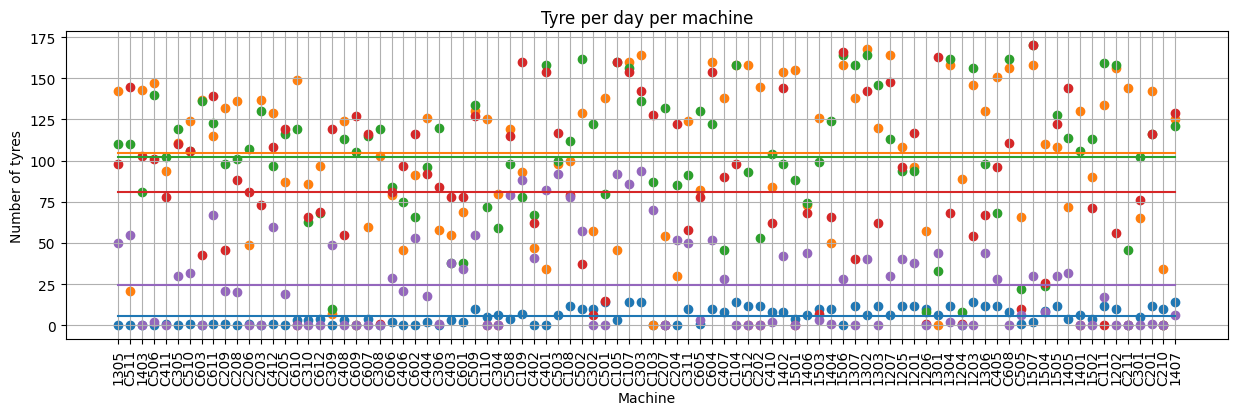

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(df_per_day)):
    y = df_per_day[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=days[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
    
plt.title("Tyre per day per machine")
plt.xlabel("Machine")
plt.ylabel("Number of tyres")
#ax.legend()
plt.show()

In [11]:
#get days with peaks of tyres
top_10_days = []
for i in range(len(df_per_day)):
    prod_mean = df_per_day[i][ColumnsInput.barcode].mean()
    if len(top_10_days) < 10:
        top_10_days.append({ColumnsOutput.day: days[i], 'N_tyres_mean': prod_mean,  'index': i})
        top_10_days.sort(key=lambda x: x['N_tyres_mean'], reverse=True)
    else:
        if prod_mean > top_10_days[-1]['N_tyres_mean']:
            top_10_days[-1] = {ColumnsOutput.day: days[i], 'N_tyres_mean': prod_mean, 'index': i}
            top_10_days.sort(key=lambda x: x['N_tyres_mean'], reverse=True)
print(top_10_days)

[{'y-m-day': '21-12-18', 'N_tyres_mean': 104.86666666666666, 'index': 1}, {'y-m-day': '21-12-19', 'N_tyres_mean': 102.11111111111111, 'index': 2}, {'y-m-day': '21-12-20', 'N_tyres_mean': 80.8, 'index': 3}, {'y-m-day': '21-12-21', 'N_tyres_mean': 24.6, 'index': 4}, {'y-m-day': '21-12-17', 'N_tyres_mean': 5.5, 'index': 0}]


In [12]:
#plot top 10 days
top_10_days_df = []
for day in top_10_days:
    top_10_days_df.append(df_per_day[day['index']])

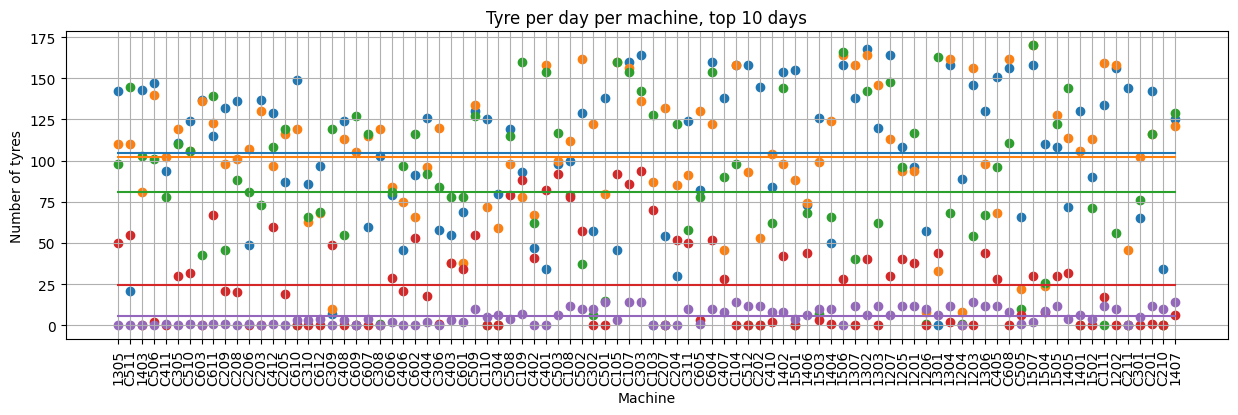

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(top_10_days_df)):
    y = top_10_days_df[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=days[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
    
plt.title("Tyre per day per machine, top 10 days")
plt.xlabel("Machine")
plt.ylabel("Number of tyres")
#ax.legend()
plt.show()

In [14]:
top_10_days_df_events = []
for day_ in top_10_days:
    top_10_days_df_events.append(df.loc[df[ColumnsOutput.day] == day_['y-m-day']])

top_10_days_df_concat = pd.concat(top_10_days_df_events, ignore_index=True)
top_10_days_df_concat_events = top_10_days_df_concat.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first','last']).value_counts()
top_10_days_df_concat_events.head()

first               last              
LO_LOADER_IN_PRESS  UN_FORK_OUT           17533
                    UN_UNLOADER_OUT        9427
                    UN_TCR_DOWN             769
                    UN_TCR_UP_LMR_DOWN      258
                    OP_PRESS_LOCKED          37
Name: count, dtype: int64

In [15]:
#fig, ax = plt.subplots(figsize=(15, 4))

In [16]:
#visualize the number of tyre per month
machines = df[ColumnsInput.machine].unique()
df_per_month = []
months = []
for month in df[ColumnsOutput.month].unique():
    months.append(str(month))
    df_per_month.append(df[df[ColumnsOutput.month] == month])
    print(month, df[df[ColumnsOutput.month] == month].shape)
for i in range(len(df_per_month)):
    df_per_month[i] = df_per_month[i].groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
    df_per_month[i] = df_per_month[i].reset_index()
    current_machines = df_per_month[i][ColumnsInput.machine].unique()
    
    tmp = []
    for mach in machines:
        if mach not in current_machines:
            tmp.append({ColumnsInput.machine: mach, ColumnsInput.barcode: 0})
    df_per_month[i] = pd.concat([df_per_month[i], pd.DataFrame(tmp)], ignore_index=True)
    df_per_month[i].sort_values(by=[ColumnsInput.machine], inplace=True)

    print(df_per_month[i].shape)

12 (972998, 11)
(90, 2)


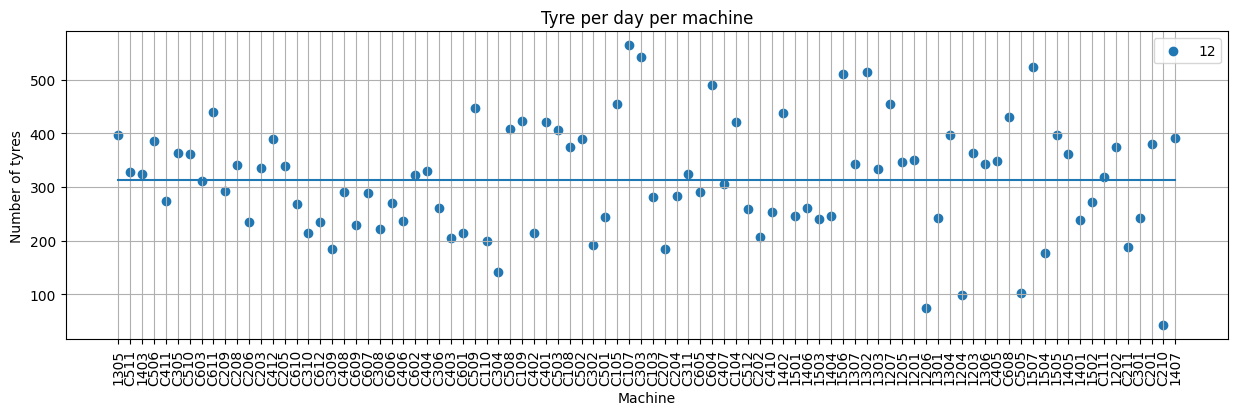

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(df_per_month)):
    y = df_per_month[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=months[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()   
plt.title("Tyre per day per machine")
plt.xlabel("Machine")  
plt.ylabel("Number of tyres")

plt.show()

In [18]:
old_vs_new = df.groupby([ColumnsInput.machine, ColumnsOutput.c_machine, ColumnsOutput.day])[ColumnsInput.barcode].nunique().reset_index()
old_vs_new_mean = old_vs_new.groupby([ColumnsInput.machine, ColumnsOutput.c_machine])[ColumnsInput.barcode].mean().reset_index()
old_vs_new_mean = old_vs_new_mean.groupby([ColumnsOutput.c_machine])[ColumnsInput.barcode].mean().reset_index()
old_vs_new_mean

,c_machine,ddc_barcode
0,False,79.242262
1,True,74.626613


In [19]:


tyre_per_machine = df.groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
tyre_per_machine = tyre_per_machine.sort_values().reset_index()
tyre_per_machine

,ddc_mch_code,ddc_barcode
0,C611,42
1,C501,74
2,C505,98
3,C511,103
4,C108,141
5,C601,176
6,C211,184
7,1405,184
8,C608,188
9,C205,191


#### Understanding if the machines in a large amount of time produce the same amount of tyres, in this case actually there are few outliers and then a a linear distribution trend

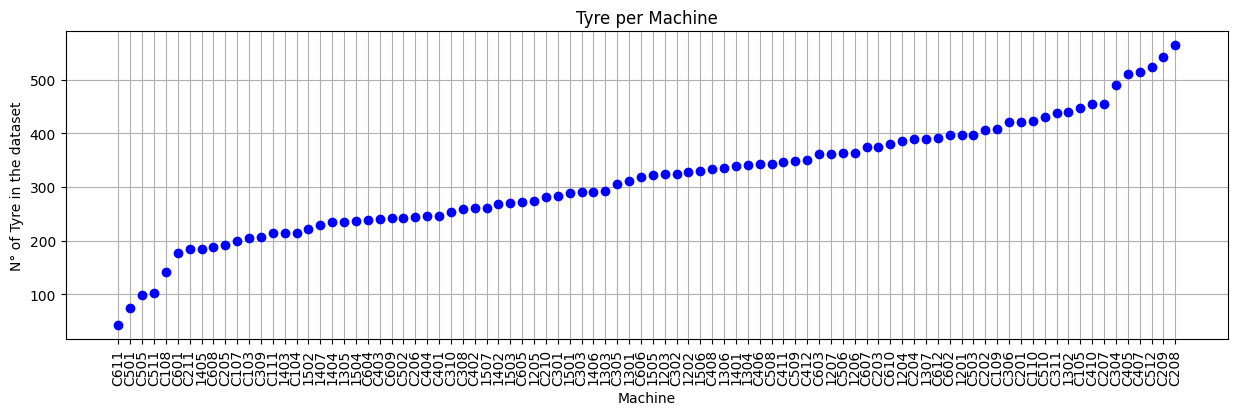

In [20]:
x = tyre_per_machine[ColumnsInput.machine]
y = tyre_per_machine[ColumnsInput.barcode]

general_plot(x, y, title = "Tyre per Machine", x_title = "Machine", y_title = "N° of Tyre in the dataset")

In [21]:
tyre_per_arm = df.groupby([ColumnsInput.machine,ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
tyre_per_arm = tyre_per_arm.sort_values(by = ColumnsInput.barcode ).reset_index()
tyre_per_arm

,index,ddc_mch_code,ddc_mch_side,ddc_barcode
0,176,C611,R,21
1,175,C611,L,21
2,152,C511,R,21
3,136,C501,R,37
4,135,C501,L,37
5,141,C505,L,37
6,116,C402,R,44
7,142,C505,R,61
8,64,C108,L,70
9,65,C108,R,71


In [22]:
#

In [23]:
tyre_per_arm = df.groupby([ColumnsInput.machine,ColumnsInput.machine_side])[ColumnsInput.barcode].nunique()
mean = tyre_per_arm.mean()
var = tyre_per_arm.std()
print("Mean = ", mean, " Var = ", var)

Mean =  157.4804469273743  Var =  54.42388157043186


#### Number of barcodes per Old and New Presses average

In [24]:
#New one should have higher production
df_by_machine = df.groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique().reset_index()
col_c_machine = 'c_machine'
df_by_machine[col_c_machine] = df_by_machine[ColumnsInput.machine].str.startswith('C')
df_by_machine.groupby(col_c_machine)[ColumnsInput.barcode].mean()

c_machine
False    302.357143
True     318.112903
Name: ddc_barcode, dtype: float64

#### Press time analysis
Understanding different time patterns and distributions in the machines or between events

In [25]:
df_min_max_time = df.groupby([ColumnsInput.machine,ColumnsOutput.c_machine,ColumnsInput.barcode])[ColumnsInput.time].agg(['min','max']).reset_index()
col_delta_time = 'delta_time'
df_min_max_time[col_delta_time] = (df_min_max_time['max'] - df_min_max_time['min']).dt.total_seconds()
df_min_max_time

,ddc_mch_code,c_machine,ddc_barcode,min,max,delta_time
0,1201,False,9435412334,2021-12-18 00:01:42,2021-12-18 00:20:57,1155.0
1,1201,False,9435412353,2021-12-18 00:33:59,2021-12-18 00:53:28,1169.0
2,1201,False,9435412363,2021-12-18 00:21:01,2021-12-18 00:40:01,1140.0
3,1201,False,9435412364,2021-12-18 00:40:04,2021-12-18 00:58:57,1133.0
4,1201,False,9435412365,2021-12-18 00:53:32,2021-12-18 01:12:39,1147.0
5,1201,False,9435412366,2021-12-18 00:59:00,2021-12-18 01:17:58,1138.0
6,1201,False,9435412368,2021-12-18 01:18:01,2021-12-18 01:36:56,1135.0
7,1201,False,9435412369,2021-12-18 01:12:43,2021-12-18 01:31:57,1154.0
8,1201,False,9435412370,2021-12-18 00:02:19,2021-12-18 00:21:34,1155.0
9,1201,False,9435412372,2021-12-18 01:32:01,2021-12-18 01:51:05,1144.0


#### Description of the distribution of the time required for the old and new presses to produce a tyre

In [26]:
df_min_max_time[col_delta_time].describe()

count    28189.000000
mean      1167.492249
std        932.714785
min        442.000000
25%       1045.000000
50%       1091.000000
75%       1170.000000
max      86855.000000
Name: delta_time, dtype: float64

#### Understanding which are the fist and last events of a barcode to check amount of time between them

In [27]:
df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first','last']).value_counts()

first                   last                  
LO_LOADER_IN_PRESS      UN_FORK_OUT               17533
                        UN_UNLOADER_OUT            9427
                        UN_TCR_DOWN                 770
                        UN_TCR_UP_LMR_DOWN          258
                        OP_PRESS_LOCKED              37
                        UN_UNLOADER_UP               24
                        OP_UNLOCK_PRESS              19
                        CURING_OFF                   14
                        UN_TCR_UP_NO_SUV             12
                        UN_VACUUM                     9
CURING_OFF              CURING_ON                     8
UN_FORK_OUT             UN_TCR_DOWN                   7
LO_LOADER_IN_PRESS      UN_SWING_IN_ARMS              7
                        OP_SQUEEZE_OFF                6
UN_VACUUM               UN_FORK_OUT                   5
LO_LOADER_IN_PRESS      OP_PRESS_MOVEMENT_UP_2        4
                        OP_PRESS_MOVEMENT_UP_3        4
 

Avarage working time for an entire cycle process by the two types of machines.

In [28]:
mean = df_min_max_time.groupby(ColumnsOutput.c_machine)[col_delta_time].mean()
var = df_min_max_time.groupby(ColumnsOutput.c_machine)[col_delta_time].std()
print("Cycle time new machine = ", mean[1], " +- ", var[1])

Cycle time new machine =  1161.4400953201846  +-  927.4542753775872


In [29]:
df_min_max_time_per_machine_mean = df_min_max_time.groupby([ColumnsInput.machine])[col_delta_time].mean()
df_min_max_time_per_machine_var = df_min_max_time.groupby(ColumnsInput.machine)[col_delta_time].std()
df_min_max_time_per_machine_mean = df_min_max_time_per_machine_mean.sort_values().reset_index()
df_min_max_time_per_machine_mean

,ddc_mch_code,delta_time
0,C505,910.938776
1,C606,925.858491
2,C204,993.254499
3,C407,997.809339
4,1407,999.182609
5,C510,1008.011601
6,C512,1010.743786
7,C405,1011.066667
8,C603,1014.875346
9,C305,1016.370492


#### Distribution of the time an entire cycle to be conclude

In [30]:
df_min_max_time_per_machine_mean.describe()

,delta_time
count,90.000000
mean,1194.584836
std,243.183257
min,910.938776
25%,1060.561971
50%,1116.592997
75%,1253.861378
max,2287.215686


##### Plot the average cycle time per machine to visualize which are the performance of each machine and che possible outliers

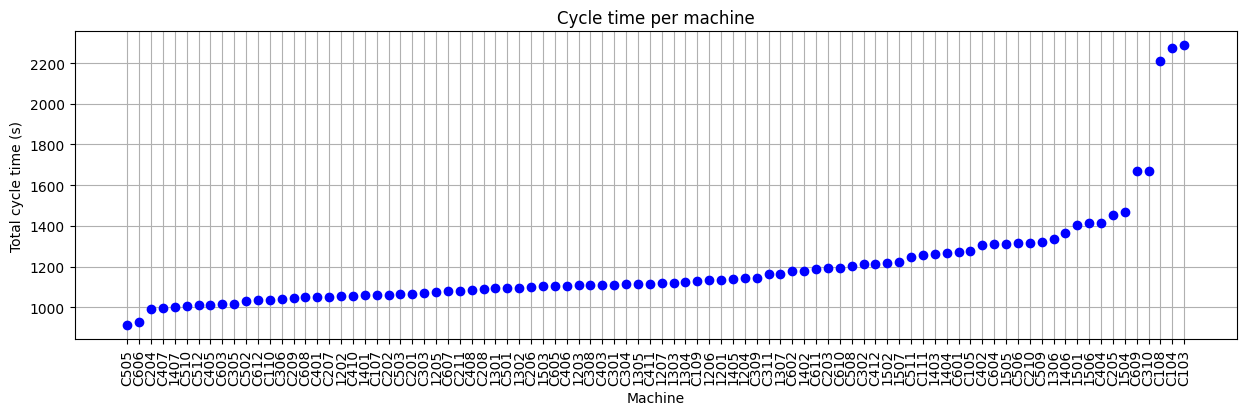

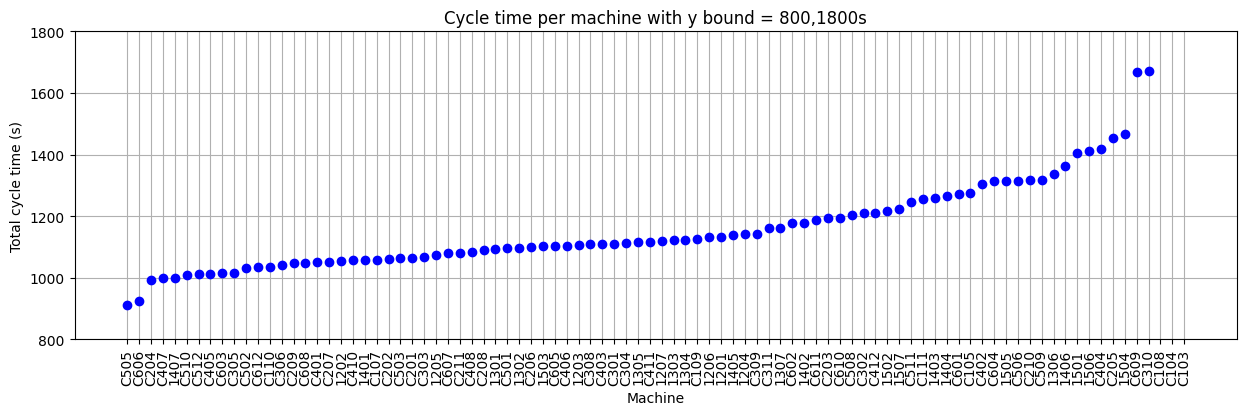

In [31]:
x = df_min_max_time_per_machine_mean[ColumnsInput.machine]
y = df_min_max_time_per_machine_mean[col_delta_time]
general_plot(x, y, title = "Cycle time per machine", x_title = "Machine", y_title = "Total cycle time (s)")
general_plot(x, y, y_bounds = [800,1800], title = "Cycle time per machine with y bound = 800,1800s", x_title = "Machine", y_title = "Total cycle time (s)")

In [32]:
df_time_per_event = df.groupby([ColumnsInput.barcode,ColumnsInput.time, ColumnsInput.event])[ColumnsInput.event].count()##### Analysing how much time require each process

In [33]:
df_time_per_event = df.groupby([ColumnsInput.ipcode, ColumnsInput.event])[ColumnsInput.time].agg('min').sort_values().reset_index()
df_time_per_event

,ddc_ipcode,ddc_ev_subcode,ddc_ev_timestamp
0,37887,LO_LOADER_IN_PRESS,2021-12-17 09:15:23
1,37887,LO_BLADDER_PRESHAPING,2021-12-17 09:15:27
2,37887,LO_BLADDER_VACUUM,2021-12-17 09:15:27
3,37887,LO_LOADER_DOWN,2021-12-17 09:15:34
4,37887,LO_TCR_DOWN,2021-12-17 09:15:38
5,37887,LO_PRESHAPING,2021-12-17 09:15:41
6,37887,LO_LOADER_RELEASE_TIRE,2021-12-17 09:15:56
7,37887,LO_LOADER_UP,2021-12-17 09:15:56
8,37887,LO_LOADER_OUT,2021-12-17 09:15:58
9,37887,CL_UNLOCK_PRESS,2021-12-17 09:16:02


Here is possible to check how much time took each process to be completed


In [34]:

event_delta_time = 'event_delta_time'
df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff().dt.total_seconds()
df_time_per_event
#df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff().fillna(timedelta(0)).apply(lambda x: x.total_seconds())
#df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff()

,ddc_ipcode,ddc_ev_subcode,ddc_ev_timestamp,event_delta_time
0,37887,LO_LOADER_IN_PRESS,2021-12-17 09:15:23,NaN
1,37887,LO_BLADDER_PRESHAPING,2021-12-17 09:15:27,4.0
2,37887,LO_BLADDER_VACUUM,2021-12-17 09:15:27,0.0
3,37887,LO_LOADER_DOWN,2021-12-17 09:15:34,7.0
4,37887,LO_TCR_DOWN,2021-12-17 09:15:38,4.0
5,37887,LO_PRESHAPING,2021-12-17 09:15:41,3.0
6,37887,LO_LOADER_RELEASE_TIRE,2021-12-17 09:15:56,15.0
7,37887,LO_LOADER_UP,2021-12-17 09:15:56,0.0
8,37887,LO_LOADER_OUT,2021-12-17 09:15:58,2.0
9,37887,CL_UNLOCK_PRESS,2021-12-17 09:16:02,4.0


In [35]:
df_time_per_event[event_delta_time].describe()

count     2150.000000
mean        79.244186
std       1049.352616
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      36655.000000
Name: event_delta_time, dtype: float64

In [36]:
df_time_per_event_mean = df_time_per_event.groupby([ColumnsInput.event])[event_delta_time].mean().reset_index()
df_time_per_event_mean = df_time_per_event_mean.sort_values(by = event_delta_time).reset_index()
df_time_per_event_mean

,index,ddc_ev_subcode,event_delta_time
0,40,UN_TCR_UP_NO_SUV,0.461538
1,43,UN_UNLOADER_UP,0.769231
2,35,UN_SWING_IN_ARMS,1.653846
3,6,CL_STOP_PAUSE_2,1.819672
4,24,OP_PRESS_STOP_PAUSE_1,1.849057
5,20,OP_PRESS_MOVEMENT_UP,1.886792
6,5,CL_STOP_PAUSE,2.049180
7,1,CL_PRESS_DOWN_2,2.081967
8,4,CL_SQUEEZE_ON,2.081967
9,10,LO_BLADDER_PRESHAPING,2.098361


In [37]:
df_time_per_event_mean.describe()

,index,event_delta_time
count,45.000000,45.000000
mean,22.000000,66.266114
std,13.133926,281.289611
min,0.000000,0.461538
25%,11.000000,2.278689
50%,22.000000,3.239130
75%,33.000000,7.852459
max,44.000000,1844.616667


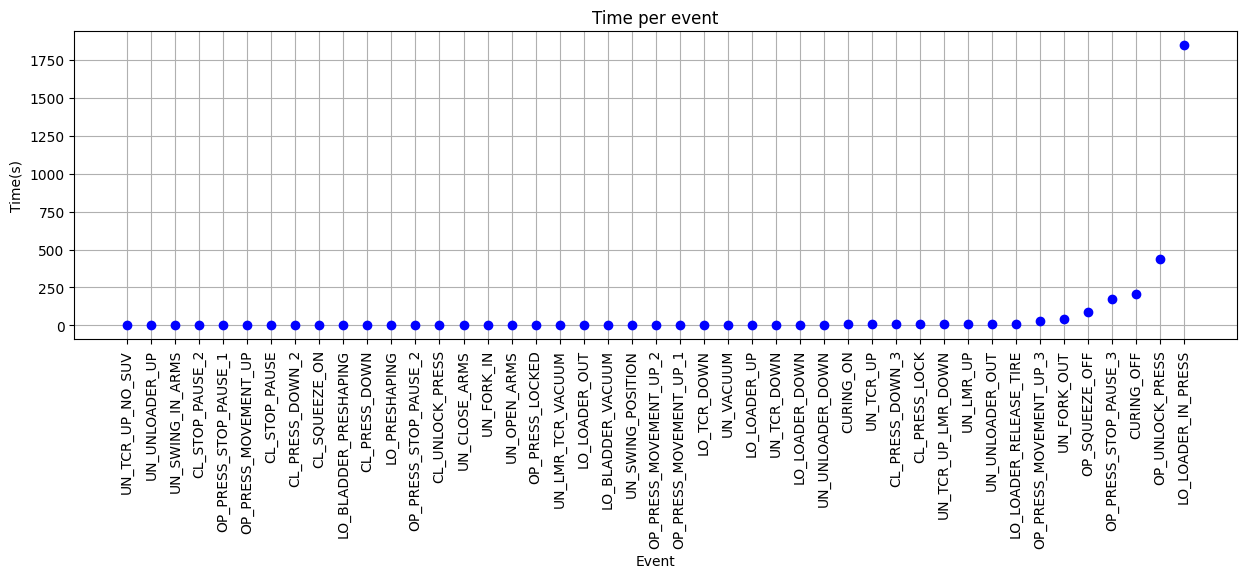

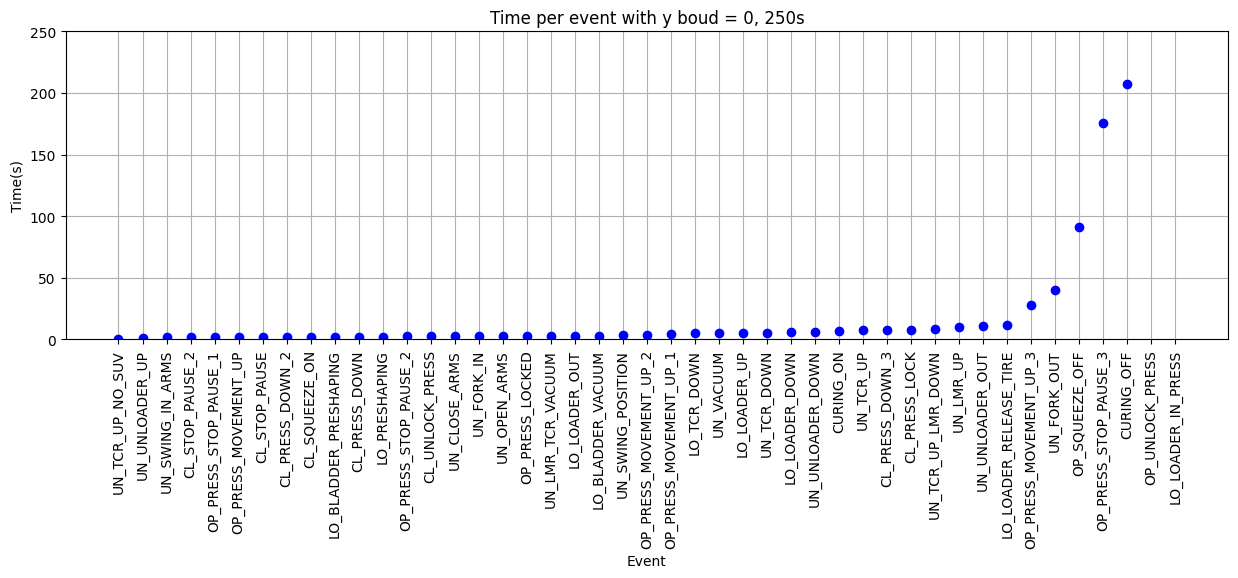

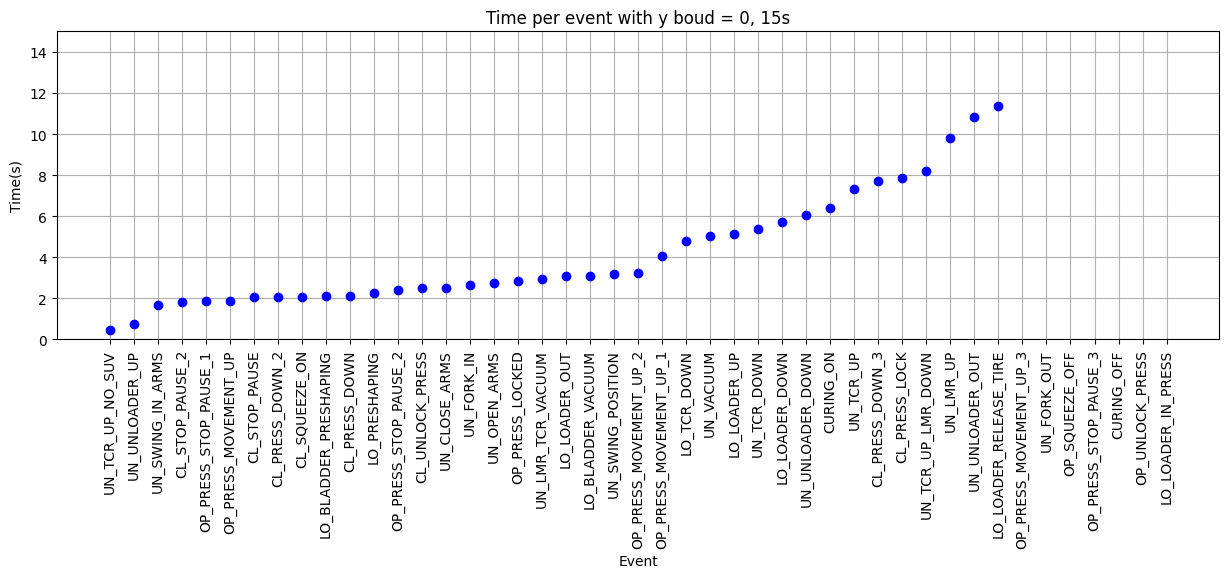

In [38]:
x = df_time_per_event_mean[ColumnsInput.event]
y = df_time_per_event_mean[event_delta_time]

general_plot(x,y, title = "Time per event", x_title = "Event", y_title = "Time(s)")

y_bounds = [0,250]
general_plot(x,y, y_bounds = y_bounds,  title = "Time per event with y boud = 0, 250s", x_title = "Event", y_title = "Time(s)")

y_bounds = [0,15]
general_plot(x,y, y_bounds = y_bounds,  title = "Time per event with y boud = 0, 15s", x_title = "Event", y_title = "Time(s)")